In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from os.path import join
from copy import deepcopy
from functools import partial
from random import sample
import pandas as pd

# from random import shuffle
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
# Import (tf) model and tokenizer structures from HuggingFace
from transformers import AutoTokenizer, pipeline, DistilBertTokenizer, DistilBertModel

In [2]:
from lib.BBData import character_dict, random_state, model_name
from lib.BBDataLoad import load_char_df, get_chatbot_predictions
# from lib.BBVisualizations import BBVisualization, PlotsEnum
from lib.metrics.triplet_nn_classifier import BarneyBotTripletClassifier
from lib.metrics.distil_bert_classifier import DistilBertClassifier
from lib.metrics.frequency import sentence_preprocess, FrequencyClassifier
from lib.visualizations.emotionsradar import EmotionsRadar

# __1 Setup__

Get the characters list and initialize the work folders

In [3]:
characters = list(character_dict.keys())
characters_noDefault = list(character_dict.keys())
characters_noDefault.remove('Default')
base_folder = os.getcwd()
data_folder = join(base_folder, 'Data', 'Characters')
model_folder = join(base_folder, 'models')
embedder_path = join(os.getcwd(), 'models', 'distilbert_embedder')
out_folder = os.getcwd().join('tmp')
figsize = (8, 8)

F_TRAIN_DistilBERT = False

## __2 State of the art__

## __2.1 Semantic Classifier__

Let's load the data. For the sake of simplicity we will perform a test just on a small test set

In [4]:
# select the character
character = 'Barney'
# read dataframe
df = pd.read_csv(join(data_folder, character, character.lower()+'_classifier.csv'))
df_train, df_test = train_test_split(df, test_size=0.15)
df_test.head()

,line,character
26912,"Yeah, me, too.",0
6042,"St. Peter's, 8:45 a.m., it's my favorite service.",1
23108,I would say Amanda.,0
22531,"I realize that you're very busy, so I'll just ...",0
31150,And that's when Lily realized what moving to R...,0


In [5]:
print('Test size:',len(df_test))

Test size: 4767


__Semantic Classifier__ is meant to labelling of whether sentences belong to a character or not.

It is a binary classifier attempting to recognize if triples of sentences are from a given character or not. We use triples since single sentences may yield too little information to be classified appropriately.

<img src="../images/Semantic_Classifier.jpg" alt="Semantic classifier" />

Now we are going to load the model...

In [6]:
# Assert there are enough sentences for the semantic classifier to perform a single evaluation
model_3plet_folder = join(model_folder, 'semantic_classifier', character)
model_3plet = BarneyBotTripletClassifier(character=character, load_path=data_folder)

... and to generate the tripletes that the model should classify.

In [7]:
df_encoded =  model_3plet.get_triplet_df(df_test, 1, random_state)
sentences, y_true = df_encoded['encoded_lines'], df_encoded['character']
df_encoded.head()

Running shuffle 0/1


100%|██████████| 755/755 [00:00<00:00, 32303.37it/s]


,character,encoded_lines
0,1,"[Oh, my God. It's horrible. It'll be along to ..."
1,0,"[Please, no., Hey., You have a butterfly tramp..."
2,1,"[... seen., Yeah, that never happens. Oh wait,..."
3,1,"[Don't wait up., Plus, the alien thing., And s..."
4,0,"[Ted, it's okay. I'm fine. And I can tell that..."


The dataset of triplets contains aggregations of 3 sentences coming from the original dataset. It is realised in order to get it in a balanced way. This in order to avoid issues in training phase.

In [8]:
print('class 0:', len(y_true[y_true==0]))
print('class 1:', len(y_true[y_true==1]))

class 0: 755
class 1: 755


Then the compute method will perform the classification of a list of sentences, by performing all the permutations in triplettes.

In [9]:
y_pred = []
for s in tqdm(sentences):
     y_pred.append(np.round(
          np.mean(model_3plet.compute(s, character, model_3plet_folder, n_sentences='all')), 0
     ))

  0%|          | 0/1510 [00:00<?, ?it/s]

100%|██████████| 1510/1510 [01:32<00:00, 16.26it/s]


It performs extremely well against the test set, that is, distinguishing the character’s true line in scripts (label).

Neural chatbot classifier test accuracy: 0.90
Neural chatbot classifier test f1 score: 0.91


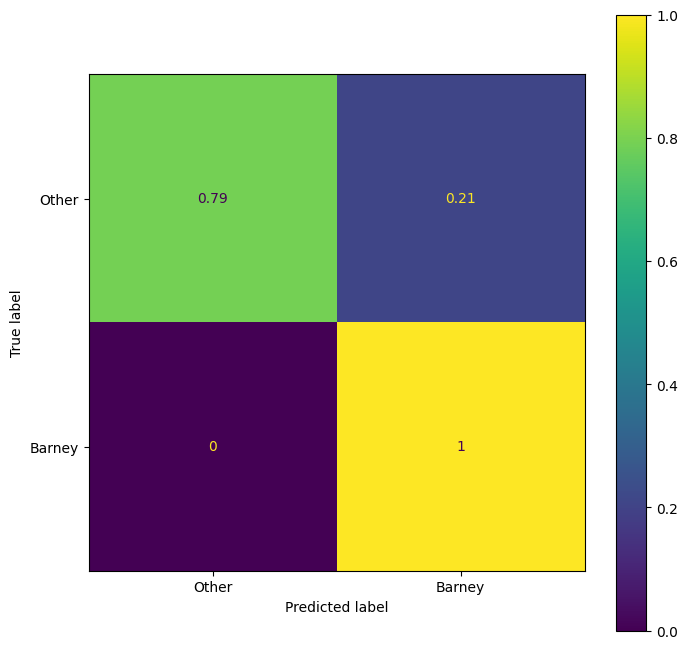

In [10]:
# print the classification report and scores
print('Neural chatbot classifier test accuracy: {:.2f}\nNeural chatbot classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Other', character])
fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

### 2.1.2 __Chatbot predictions__

Let's now try to run the experiment on the chatbot predicions

In [11]:
file_name = 'barney_prediction_sampling.json'
# Load tokenizer, and set its padding token to the symbol #, which is removed in preprocessing from all datasets
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=os.path.join(base_folder, "cache"))
tokenizer.pad_token = '#'

In [12]:
chatbot_predictions = get_chatbot_predictions(None, None, file_name, None, character, tokenizer, base_folder)
chatbot_predictions = [tokenizer.decode(s, skip_special_tokens=True) for s in chatbot_predictions]
chatbot_predictions[:5]

Loading predictions from stored file
Loaded predictions from stored file


["Oh, God, you're gonna be in that one.",
 'The Meatball sub.',
 'I called three emergency personnel to help me get out of the apartment.',
 'How much fun is this?',
 "That's it? You're being Barney's best friend?"]

In [13]:
df_test = df_test.reset_index(drop=True)
df_test.head()

,line,character
0,"Yeah, me, too.",0
1,"St. Peter's, 8:45 a.m., it's my favorite service.",1
2,I would say Amanda.,0
3,"I realize that you're very busy, so I'll just ...",0
4,And that's when Lily realized what moving to R...,0


In [14]:
j = 0
for i in df_test.index:
    if df_test['character'][i] == 1:
        df_test['line'][i] = chatbot_predictions[j]
        j += 1
    if len(chatbot_predictions) == j: 
        break
df_test = df_test[:j]
df_test

C:\Users\User\AppData\Local\Temp\ipykernel_20928\565759476.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['line'][i] = chatbot_predictions[j]


,line,character
0,"Yeah, me, too.",0
1,"Oh, God, you're gonna be in that one.",1
2,I would say Amanda.,0
3,"I realize that you're very busy, so I'll just ...",0
4,And that's when Lily realized what moving to R...,0
...,...,...
517,"Listen, Ted, I can't really talk right... '93?...",0
518,Tonight we celebrate the very best in broadcas...,0
519,"His favorite grandson is getting married, Ted....",0
520,"Yeah, so?",0


In [15]:
df_encoded =  model_3plet.get_triplet_df(df_test, 1, random_state)
sentences, y_true = df_encoded['encoded_lines'], df_encoded['character']
df_encoded.head()

Running shuffle 0/1


100%|██████████| 91/91 [00:00<00:00, 32880.92it/s]


,character,encoded_lines
0,1,"[Oh, we are., Oh, my God!, Chain of stairs.]"
1,0,[Here is another. More random bitch to my birt...
2,1,[Hey! I was just saying that you were a little...
3,0,"[You have not seen the show?, You can't have t..."
4,1,"[I guess we all paid for dinner., How much fun..."


In [16]:
print('class 0:', len(y_true[y_true==0]))
print('class 1:', len(y_true[y_true==1]))

class 0: 91
class 1: 91


In [17]:
y_pred = []
for s in tqdm(sentences):
     y_pred.append(np.round(
          np.mean(model_3plet.compute(s, character, model_3plet_folder, n_sentences='all')), 0
     ))

100%|██████████| 182/182 [00:05<00:00, 34.43it/s]


The classifier here instead suffers from huge variance when working on sentences generated from chatbots (chatbot). Indeed the problem to recognize the chatbot is still very hard.

Neural chatbot classifier test accuracy: 0.53
Neural chatbot classifier test f1 score: 0.45


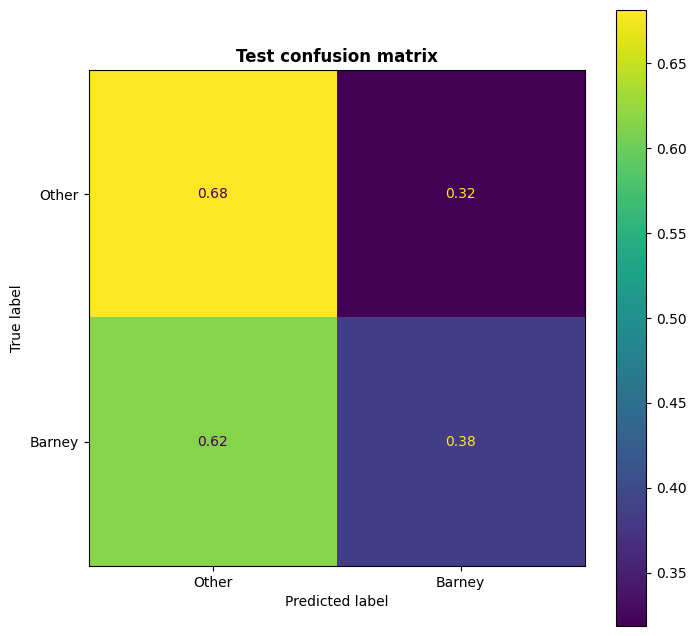

In [18]:
# print the classification report and scores
print('Neural chatbot classifier test accuracy: {:.2f}\nNeural chatbot classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Other', character])
fig, ax = plt.subplots(figsize=figsize)
ax.set_title(f'Test confusion matrix', fontweight='bold')
disp.plot(ax=ax)

We attempted also in comparing two different characters using the classifier of the first character usually results in a correct guess and in greater variance for the wrong one, but not always. For the sake of simplicity we will not go in deeper details for what concern this model.

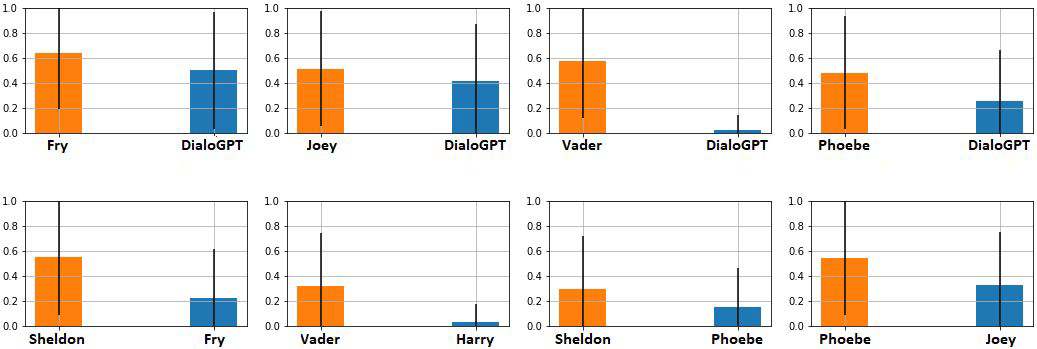

## __2.2 Emotion Classifier__

Now we are going to take a pre-trained neural emotion classifier and to use it to classify sentences from a character. More precisely we consider the average over the sentences as the emotion “fingerprint” of that character. We tried many variations to improve previous
results: different model, threshold or do a count of the best emotions only

In [5]:
# Load tokenizer, and set its padding token to the symbol #, which is removed in preprocessing from all datasets
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=os.path.join(base_folder, "cache"))
tokenizer.pad_token = '#'

Here we load the dataset...

In [6]:
# select the character
character = 'Barney'
file_name = character.lower()+'_prediction_sampling.json'
# read dataframe
df = pd.read_csv(os.path.join(data_folder, character, f'{character}.csv'))
chatbot_predictions = get_chatbot_predictions(None, None, file_name, None, character, tokenizer, base_folder)
chatbot_predictions = [tokenizer.decode(s, skip_special_tokens=True) for s in chatbot_predictions]
sentences = df['response'].to_list()

Loading predictions from stored file
Loaded predictions from stored file


... and load the [emotion classifier](https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion)

In [7]:
emotion_classifier = pipeline("text-classification", model='bhadresh-savani/distilbert-base-uncased-emotion',
                              return_all_scores=True)

/usr/local/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [8]:
result = {'score': {}, 'std': {}}
output = emotion_classifier(sentences)

In [9]:
# Initialize lists of scores for each emotion
for emotion_dict in output[0]:
    result['score'][emotion_dict['label']] = []
# For each sentence...
for elem in output:
    # Append scores to the scores list for each emotion
    for emotion_dict in elem:
        result['score'][emotion_dict['label']].append(emotion_dict['score'])
# For each emotion label...
for emotion_dict in output[0]:
    # Append emotion as a separate entry in the result dictionary
    emotion = emotion_dict['label']
    # Transform lists of scores into single std and mean values
    result['std'][emotion] = np.std(np.array(result['score'][emotion]))
    result['score'][emotion] = np.mean(np.array(result['score'][emotion]))
# Return a dictionary with lists for labels, avg scores and stds, in corresponding order
result['label'] = list(result['score'].keys())
result['score'] = list(result['score'].values())
result['std'] = list(result['std'].values())
result

{'score': [0.0864908300056685,
  0.4031424635679138,
  0.02963537962765485,
  0.3774144738739534,
  0.09106193038221658,
  0.012254922831190916],
 'std': [0.2300232808966156,
  0.4065923637508026,
  0.13999348448357918,
  0.3678006118831381,
  0.1880018394884175,
  0.08060208802110608],
 'label': ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']}

In [10]:
emotions = result['label']
labels = result['score']

Now let's compute the emotion scores on the chatbot responses

In [11]:
result = {'score': {}, 'std': {}}
output = emotion_classifier(chatbot_predictions)

In [12]:
# Initialize lists of scores for each emotion
for emotion_dict in output[0]:
    result['score'][emotion_dict['label']] = []
# For each sentence...
for elem in output:
    # Append scores to the scores list for each emotion
    for emotion_dict in elem:
        result['score'][emotion_dict['label']].append(emotion_dict['score'])
# For each emotion label...
for emotion_dict in output[0]:
    # Append emotion as a separate entry in the result dictionary
    emotion = emotion_dict['label']
    # Transform lists of scores into single std and mean values
    result['std'][emotion] = np.std(np.array(result['score'][emotion]))
    result['score'][emotion] = np.mean(np.array(result['score'][emotion]))
# Return a dictionary with lists for labels, avg scores and stds, in corresponding order
result['label'] = list(result['score'].keys())
result['score'] = list(result['score'].values())
result['std'] = list(result['std'].values())
result

{'score': [0.0983512363524207,
  0.3969137964258539,
  0.02341386576298998,
  0.39206532480417233,
  0.07623960344833458,
  0.0130161681734263],
 'std': [0.2532222810674703,
  0.4110804271839151,
  0.12311367652639678,
  0.37927834035921104,
  0.16481737077036354,
  0.09169673662333819],
 'label': ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']}

In [13]:
predictions = result['score']

Results on emotion analysis were, unfortunately, disappointing: although single sentences can be classified more or less correctly, their average quickly degrades to pretty much the same output. We have found no significant differences with respect to the dataset taken under consideration.

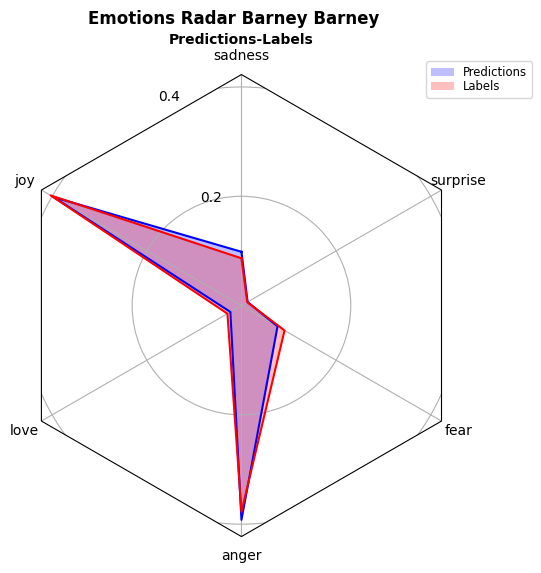

In [14]:
EmotionsRadar(emotions, predictions, labels, character).plotEmotionsRadar('Emotions Radar '+character)

Let's repeat the experiment with another character, maybe with a different personality.

Results are underwhelming: there is general overlapping between all models and correlations between emotion vectors of different characters is almost always close to 1.

Moreover __strong bias__ on emotions of `joy` and `anger`, sometimes sadness.

Loading predictions from stored file
Loaded predictions from stored file


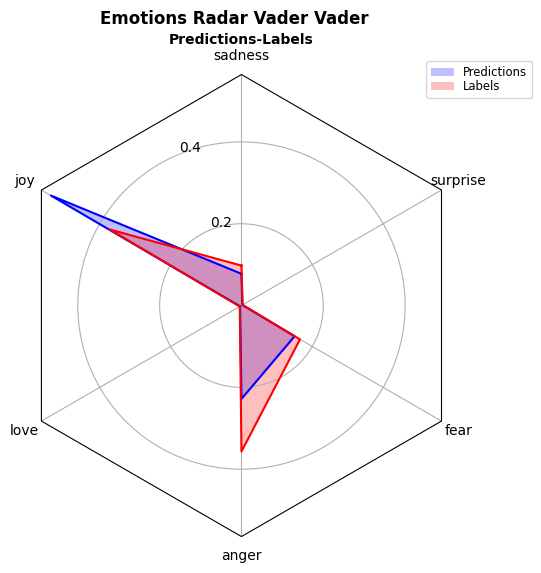

In [15]:
# select the character
character = 'Vader'
file_name = character.lower()+'_prediction_sampling.json'
# read dataframe
df = pd.read_csv(os.path.join(data_folder, character, f'{character}.csv'))
sentences = df['response'].to_list()
chatbot_predictions = get_chatbot_predictions(None, None, file_name, None, character, tokenizer, base_folder)
chatbot_predictions = [tokenizer.decode(s, skip_special_tokens=True) for s in chatbot_predictions]

result = {'score': {}, 'std': {}}
output = emotion_classifier(sentences)

# Initialize lists of scores for each emotion
for emotion_dict in output[0]:
    result['score'][emotion_dict['label']] = []
# For each sentence...
for elem in output:
    # Append scores to the scores list for each emotion
    for emotion_dict in elem:
        result['score'][emotion_dict['label']].append(emotion_dict['score'])
# For each emotion label...
for emotion_dict in output[0]:
    # Append emotion as a separate entry in the result dictionary
    emotion = emotion_dict['label']
    # Transform lists of scores into single std and mean values
    result['std'][emotion] = np.std(np.array(result['score'][emotion]))
    result['score'][emotion] = np.mean(np.array(result['score'][emotion]))
# Return a dictionary with lists for labels, avg scores and stds, in corresponding order
result['label'] = list(result['score'].keys())
result['score'] = list(result['score'].values())
result['std'] = list(result['std'].values())

# store emotions keys
emotions = result['label']
# store emotions score on script dataset
labels = result['score']

result = {'score': {}, 'std': {}}
output = emotion_classifier(chatbot_predictions)

# Initialize lists of scores for each emotion
for emotion_dict in output[0]:
    result['score'][emotion_dict['label']] = []
# For each sentence...
for elem in output:
    # Append scores to the scores list for each emotion
    for emotion_dict in elem:
        result['score'][emotion_dict['label']].append(emotion_dict['score'])
# For each emotion label...
for emotion_dict in output[0]:
    # Append emotion as a separate entry in the result dictionary
    emotion = emotion_dict['label']
    # Transform lists of scores into single std and mean values
    result['std'][emotion] = np.std(np.array(result['score'][emotion]))
    result['score'][emotion] = np.mean(np.array(result['score'][emotion]))
# Return a dictionary with lists for labels, avg scores and stds, in corresponding order
result['label'] = list(result['score'].keys())
result['score'] = list(result['score'].values())
result['std'] = list(result['std'].values())

# store predictions
predictions = result['score']

# plot the emotion radar
EmotionsRadar(emotions, predictions, labels, character).plotEmotionsRadar('Emotions Radar '+character)

## __2.3 Frequency Chatbot Classifier__

Prepare the dataset for `Frequency Classifier`. 

In this case we need a dictionary built as following: 
$$\mathbb{D}=\{c: \tilde{D}_c\} \hspace{1cm}\forall c \in C$$
this is a dictionary for which each key corresponds to the name of a character with its related value asssociated which is instead the list of o its script lines, preprocessed.

In [4]:
# prepare the dataset of all documents
character_docs = dict()
# foreach character in ours dataset
for character in characters:
    if character == 'Default':
        # read Default dataset and sample 0.02 fraction of the whole dataset
        df = pd.read_csv(os.path.join(data_folder, character, f'{character}.tsv'), 
                         names=[character, 'response'], sep='\t')
        df = df.sample(frac=0.02, random_state=random_state)
        df['response'] = df['response'].apply(lambda x: x[3:])
        df[character] = df[character].apply(lambda x: x[3:])
    else:
        # read other dataset 
        df = pd.read_csv(os.path.join(data_folder, character, f'{character}.csv'))
    # convert dataframes to list
    tmp_list = df['response'].tolist()
    # attach the list to the dictionary of documents of character
    character_docs[character] = tmp_list

In [5]:
# preprocess datasets
character_docs_prepr = deepcopy(character_docs)
for character in characters:
    for i in tqdm(range(len(character_docs[character]))):
        sentence, relevant = sentence_preprocess(character_docs[character][i])
        if relevant:
            character_docs_prepr[character][i] = sentence

100%|██████████| 14747/14747 [00:01<00:00, 13494.98it/s]


In [6]:
# test size for splitting
test_size = 0.33
# prepare the dictionaries of train and set
character_docs_train = {}
character_docs_test = {}
n_docs = 0
# for each character in ours data
for c in characters:
    # shuffle data
    character_docs_prepr[c] = shuffle(character_docs_prepr[c], random_state=random_state)
    # split the dataset in train e test set
    end_idx = int(len(character_docs_prepr[c]) * test_size)
    character_docs_train[c] = character_docs_prepr[c][end_idx:]
    n_docs += len(character_docs_prepr[c][end_idx:])
    character_docs_test[c] = character_docs_prepr[c][:end_idx]

In [7]:
# takes the list of characters without Default
characters_noDefault = characters.copy()
characters_noDefault.remove('Default')
# load dataset in hugging face dictionary model
character_hg = {c:None for c in characters_noDefault}
for c in characters_noDefault:
    # extract the character checkpoint
    character_checkpoint = join(data_folder, c, character_dict[c]['checkpoint_folder'])
    # load the dataset dict of each character
    character_hg[c] = load_char_df(c, base_folder)

Found cached dataset csv (c:/Users/User/Documents/Unibo/TM/Project/ChatBot-Personality-Recognition/notebooks/cache/csv/default-256bbbeaf460349a/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at c:\Users\User\Documents\Unibo\TM\Project\ChatBot-Personality-Recognition\notebooks\cache\csv\default-256bbbeaf460349a\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-8c74c143f0a5cb95.arrow and c:\Users\User\Documents\Unibo\TM\Project\ChatBot-Personality-Recognition\notebooks\cache\csv\default-256bbbeaf460349a\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-058395b36146446e.arrow
Loading cached split indices for dataset at c:\Users\User\Documents\Unibo\TM\Project\ChatBot-Personality-Recognition\notebooks\cache\csv\default-256bbbeaf460349a\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-43b42e4340353674.arrow and c:\Users\User\Documents\Unibo\TM\Project\ChatBot-Personality-Recognition\notebooks\cache\csv\default-256bbbeaf460349a\0.0.0\6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1\cache-a8179f594fa3146d.arrow


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to c:/Users/User/Documents/Unibo/TM/Project/ChatBot-Personality-Recognition/notebooks/cache/csv/default-e7e6560dc257631d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to c:/Users/User/Documents/Unibo/TM/Project/ChatBot-Personality-Recognition/notebooks/cache/csv/default-e5359a2cdb2a5854/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to c:/Users/User/Documents/Unibo/TM/Project/ChatBot-Personality-Recognition/notebooks/cache/csv/default-dc6ad647d79056b6/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to c:/Users/User/Documents/Unibo/TM/Project/ChatBot-Personality-Recognition/notebooks/cache/csv/default-01821a0c1f6698d5/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to c:/Users/User/Documents/Unibo/TM/Project/ChatBot-Personality-Recognition/notebooks/cache/csv/default-bd1e4e8ee88efed0/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to c:/Users/User/Documents/Unibo/TM/Project/ChatBot-Personality-Recognition/notebooks/cache/csv/default-f4282534a8d46419/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to c:/Users/User/Documents/Unibo/TM/Project/ChatBot-Personality-Recognition/notebooks/cache/csv/default-550f349d6e877bfd/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Look at the problem as an Information Retrieval (IR) approach. The goal is to return the documents (w.r.t the train character script lines) ordered according to their similarity with respect to the query (w.r.t the chatbot responses).

<img src="../images/Frequency_Classifier.jpg" alt="Frequency classifier" />

In [8]:
# Initialize and train the FrequencyClassifier
ctfidf_classifier = FrequencyClassifier(characters, mode='c-tf-idf')
ctfidf_classifier.train(list(character_docs_train.values()))

c-TF-IDF classifier training accuracy: 1.00
c-TF-IDF classifier training f1 score: 1.00


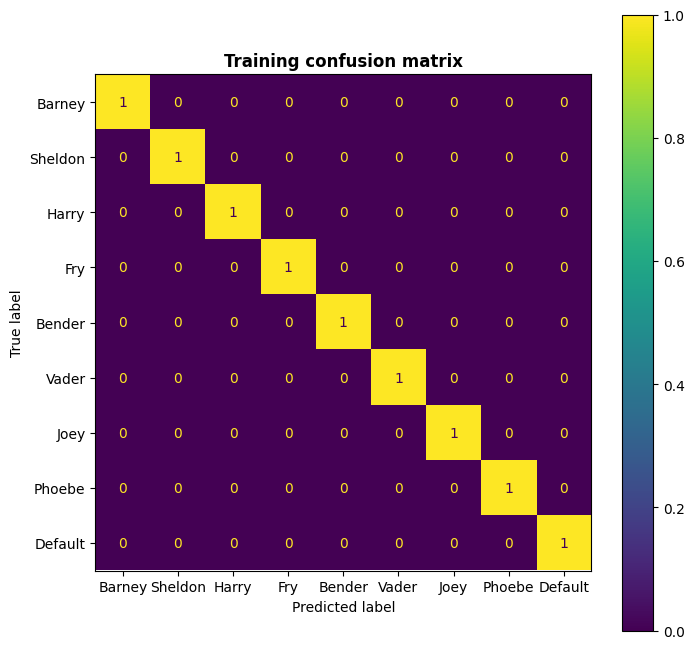

In [9]:
# real y value 
y_true = [characters.index(c) for c in characters]
# compute y predicted by the model
y_pred = []
raw_predictions = {c:[] for c in characters}
for c in characters:
    # compute the prediction
    prediction = ctfidf_classifier.predict(character_docs_test[c])
    raw_predictions[c].append(prediction)
    # extract the argmax of the prediction which is the index of the character predicted
    y_pred.append(np.argmax(list(prediction.values())))

# print the classification report and scores
print('c-TF-IDF classifier training accuracy: {:.2f}\nc-TF-IDF classifier training f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
     )
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Training confusion matrix', fontweight='bold')
disp.plot(ax=ax)

In [10]:
# divide a list in sublists of equal size of elements
def subgroup_list(l, n):
    return [l[e:e+n] for e in range(0, len(l), n)]

In order to understand the real behaviour of this model, we will divide the test set in lists of subgroups of 3 and 10 consecutive lines, to add a level of complexity.

Subgroups of 3 consecutive lines

c-TF-IDF classifier test accuracy: 0.70
c-TF-IDF classifier test f1 score: 0.65


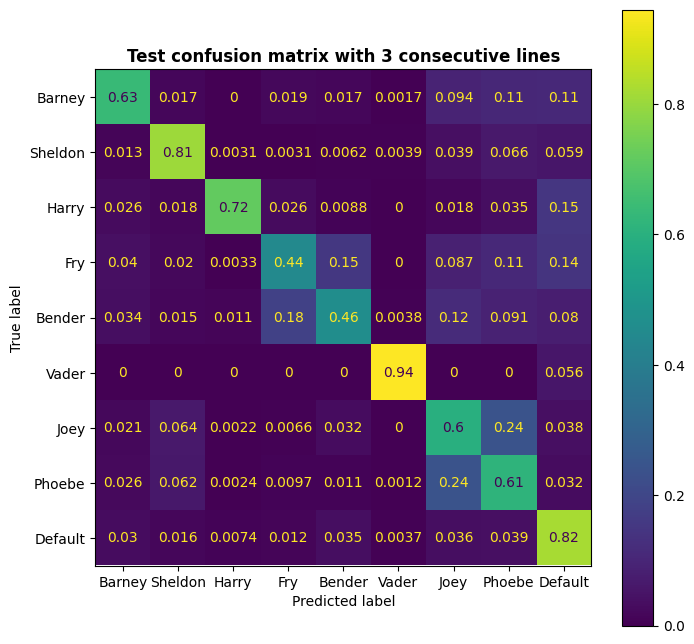

In [11]:
# 3 consecutive lines
m = 3
# real y value 
y_true = [characters.index(c) for c in characters for d in subgroup_list(character_docs_test[c], m)]
# compute y predicted by the model
y_pred = []
raw_predictions = {c:[] for c in characters}
for c in characters:
    # document d to predict compose by 3 consecutive lines
    for d in subgroup_list(character_docs_test[c], m):
        # compute the prediction
        prediction = ctfidf_classifier.predict(d)
        raw_predictions[c].append(prediction)
        # extract the argmax of the prediction which is the index of the character predicted
        y_pred.append(np.argmax(list(prediction.values())))

# print the classification report and scores
print('c-TF-IDF classifier test accuracy: {:.2f}\nc-TF-IDF classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title(f'Test confusion matrix with {m} consecutive lines', fontweight='bold')
disp.plot(ax=ax)

c-TF-IDF classifier test accuracy: 0.91
c-TF-IDF classifier test f1 score: 0.90


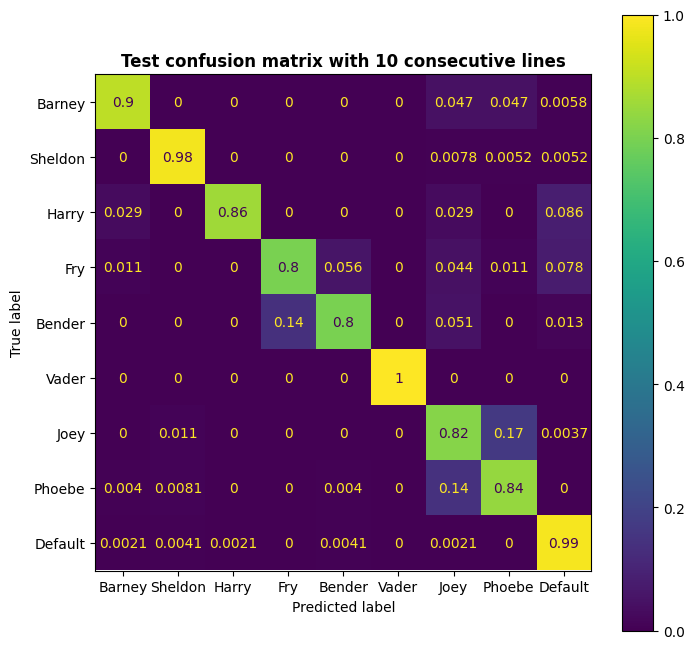

In [12]:
# 10 consecutive lines
m = 10
# real y value 
y_true = [characters.index(c) for c in characters for d in subgroup_list(character_docs_test[c], m)]
# compute y predicted by the model
y_pred = []
raw_predictions = {c:[] for c in characters}
for c in characters:
    # document d to predict compose by 3 consecutive lines
    for d in subgroup_list(character_docs_test[c], m):
        # compute the prediction
        prediction = ctfidf_classifier.predict(d)
        raw_predictions[c].append(prediction)
        # extract the argmax of the prediction which is the index of the character predicted
        y_pred.append(np.argmax(list(prediction.values())))

# print the classification report and scores
print('c-TF-IDF classifier test accuracy: {:.2f}\nc-TF-IDF classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title(f'Test confusion matrix with {m} consecutive lines', fontweight='bold')
disp.plot(ax=ax)

Thus as we can, the amount of sentences in queries can largely affect the evaluation, increasing the confidence in deciding which should be the character in prediction

It can be noticed also that the problem seems to be much difficult for distinguishing characters coming from a common tv show (e.g. _Fry_-_Bender_ from _Futurama_ and _Joey_-_Phoebe_ from _Friends_). A possible explaination to this results could come from the authors's script style of a given tv show, or by common topics present in the characters lines. 

### 2.3.2 __Chatbot predictions__

Test the model on the chatbots responses and check the predictions of the Frequency classifier

In [13]:
file_name = 'barney_prediction_sampling.json'
# Load tokenizer, and set its padding token to the symbol #, which is removed in preprocessing from all datasets
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=os.path.join(base_folder, "cache"))
tokenizer.pad_token = '#'

In [14]:
# prepare the dataset of all documents
chatbot_docs = dict()
# foreach character in ours dataset
for character in characters_noDefault:
    file_name = character.lower() + '_prediction_sampling.json'
    # read other dataset 
    chatbot_predictions = get_chatbot_predictions(None, None, file_name, None, character, tokenizer, base_folder)
    # attach the list to the dictionary of documents of character
    chatbot_docs[character] = [tokenizer.decode(s, skip_special_tokens=True) for s in chatbot_predictions]

Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file
Loading predictions from stored file
Loaded predictions from stored file


In [15]:
# preprocess datasets
chatbot_docs_prepr = deepcopy(chatbot_docs)
for character in characters_noDefault:
    for i in tqdm(range(len(chatbot_docs[character]))):
        sentence, relevant = sentence_preprocess(chatbot_docs[character][i])
        if relevant:
            chatbot_docs_prepr[character][i] = sentence

100%|██████████| 751/751 [00:00<00:00, 14580.81it/s]


In [16]:
# initialize the frequency classifier and train over the documents
tfidf_classifier = FrequencyClassifier(characters, mode='c-tf-idf')
tfidf_classifier.train(list(character_docs.values()))

c-TF-IDF classifier test accuracy: 0.72
c-TF-IDF classifier test f1 score: 0.65


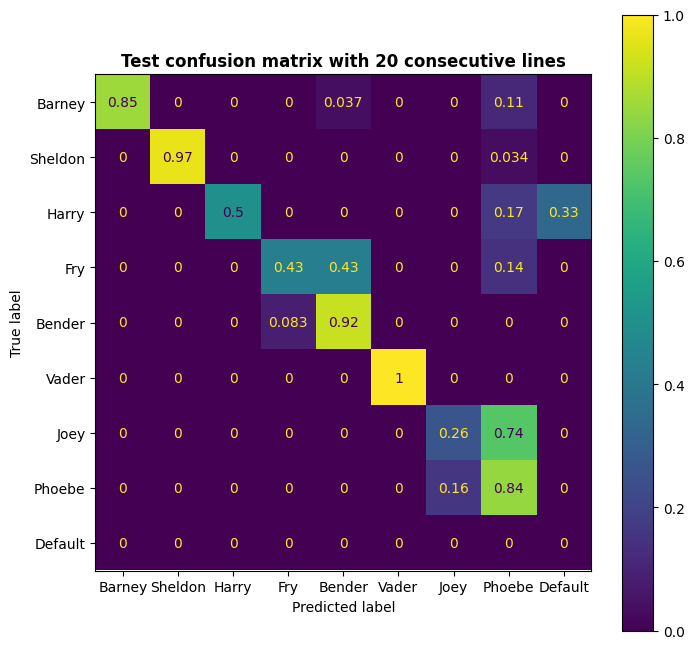

In [17]:
# size of each subgroup
m = 20

y_true = []
y_pred = []

for c in characters_noDefault:
    # Takes a subset of the testset as sample question
    for d in subgroup_list(chatbot_docs_prepr[c], m):
        # compute the prediction
        prediction = ctfidf_classifier.predict(d)
        # extract the argmax of the prediction which is the index of the character predicted
        y_pred.append(np.argmax(list(prediction.values())))
        y_true.append(characters_noDefault.index(c))

# print the classification report and scores
print('c-TF-IDF classifier test accuracy: {:.2f}\nc-TF-IDF classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters)
fig, ax = plt.subplots(figsize=figsize)
ax.set_title(f'Test confusion matrix with {m} consecutive lines', fontweight='bold')
disp.plot(ax=ax)

By the way results are very surprising also with the chatbot responses, but the problem of characters coming from common tv show is still there, confirming the complexity of this task.

## 2.4 __DistilBERT Classifier__

Another approach we attempted follow the concept of metric learning, with auxiliary loss function _Triplet Loss_.

This model is divided into:
* __DistilBert Embedder__, which creates the embeddings
* __KNN Classifier__, which performs classification in the embedded space

<img src="../images/DistilBERT_Classifier.jpg" alt="DistilBERT Classifier" />

Notice that the previous version of this model:
* took 9 sentences in input, outputs the embedding vector
* was trained with the Triplet Loss
* used __Semi-Hard Negative Mining__ to filter the training data with multiple passes

By the way, the previous model went lost due to memory corruption issues. Nonetheless, a new training process had been performed (adding also Default dataset which wasn't present in previous version).

In [4]:
distilbert_model = DistilBertClassifier(embedder_path=embedder_path, 
                                        use_cuda=True, 
                                        from_pretrained=True, 
                                        n_triplets_x_anchor=3)
# add default
distilbert_model.set_characters(characters)

Here the model is loaded and the kNN is fitted

Train also DistilBERT embedder...
Creating triplets...


100%|██████████| 8240/8240 [00:11<00:00, 700.25it/s]


Creating triplets...


100%|██████████| 468/468 [00:00<00:00, 11700.15it/s]


Training embedder
####################################################################################################
step 1/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:00<00:00, 258576.63it/s]

Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 47.79%	(+47.79%)

Dataset lenght    : 34152

Train Accuracy    : 46.05%	(+46.05%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/267 [00:00<?, ?it/s]

Iteration:   0%|          | 0/267 [00:00<?, ?it/s]

Iteration:   0%|          | 0/267 [00:00<?, ?it/s]

Iteration:   0%|          | 0/267 [00:00<?, ?it/s]

Iteration:   0%|          | 0/267 [00:00<?, ?it/s]

####################################################################################################
step 2/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:00<00:00, 78589.02it/s]


Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 45.73%	(-2.07%)

Dataset lenght    : 39435

Train Accuracy    : 53.18%	(+7.12%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/309 [00:00<?, ?it/s]

Iteration:   0%|          | 0/309 [00:00<?, ?it/s]

Iteration:   0%|          | 0/309 [00:00<?, ?it/s]

Iteration:   0%|          | 0/309 [00:00<?, ?it/s]

Iteration:   0%|          | 0/309 [00:00<?, ?it/s]

####################################################################################################
step 3/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:00<00:00, 245803.11it/s]

Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 51.85%	(+4.06%)

Dataset lenght    : 44497

Train Accuracy    : 60.00%	(+6.83%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/348 [00:00<?, ?it/s]

Iteration:   0%|          | 0/348 [00:00<?, ?it/s]

Iteration:   0%|          | 0/348 [00:00<?, ?it/s]

Iteration:   0%|          | 0/348 [00:00<?, ?it/s]

Iteration:   0%|          | 0/348 [00:00<?, ?it/s]

####################################################################################################
step 4/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:00<00:00, 246472.15it/s]

Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 52.14%	(+0.28%)

Dataset lenght    : 48638

Train Accuracy    : 65.59%	(+5.58%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/380 [00:00<?, ?it/s]

Iteration:   0%|          | 0/380 [00:00<?, ?it/s]

Iteration:   0%|          | 0/380 [00:00<?, ?it/s]

Iteration:   0%|          | 0/380 [00:00<?, ?it/s]

Iteration:   0%|          | 0/380 [00:00<?, ?it/s]

####################################################################################################
step 5/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:00<00:00, 241701.54it/s]

Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 36.13%	(-16.0%)

Dataset lenght    : 51761

Train Accuracy    : 69.80%	(+4.21%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/405 [00:00<?, ?it/s]

Iteration:   0%|          | 0/405 [00:00<?, ?it/s]

Iteration:   0%|          | 0/405 [00:00<?, ?it/s]

Iteration:   0%|          | 0/405 [00:00<?, ?it/s]

Iteration:   0%|          | 0/405 [00:00<?, ?it/s]

####################################################################################################
step 6/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:00<00:00, 243198.82it/s]

Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 44.52%	(-7.62%)

Dataset lenght    : 53169

Train Accuracy    : 71.69%	(+1.9%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/416 [00:00<?, ?it/s]

Iteration:   0%|          | 0/416 [00:00<?, ?it/s]

Iteration:   0%|          | 0/416 [00:00<?, ?it/s]

Iteration:   0%|          | 0/416 [00:00<?, ?it/s]

Iteration:   0%|          | 0/416 [00:00<?, ?it/s]

####################################################################################################
step 7/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:00<00:00, 242744.45it/s]

Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 33.88%	(-18.26%)

Dataset lenght    : 53008

Train Accuracy    : 71.48%	(-0.22%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/415 [00:00<?, ?it/s]

Iteration:   0%|          | 0/415 [00:00<?, ?it/s]

Iteration:   0%|          | 0/415 [00:00<?, ?it/s]

Iteration:   0%|          | 0/415 [00:00<?, ?it/s]

Iteration:   0%|          | 0/415 [00:00<?, ?it/s]

####################################################################################################
step 8/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:00<00:00, 237989.08it/s]

Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 32.55%	(-19.59%)

Dataset lenght    : 55141

Train Accuracy    : 74.35%	(+2.66%)

Easy Positives    :      0	(+0)
############################################################ 

Training...


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

Iteration:   0%|          | 0/431 [00:00<?, ?it/s]

####################################################################################################
step 9/12
Creating all updated embeddings...


Batches:   0%|          | 0/870 [00:00<?, ?it/s]

Checking triplets hardness...


100%|██████████| 74160/74160 [00:01<00:00, 72554.25it/s]


Filtering dataset...
Validation...
Encoding anchors, positives and negatives


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

############################################################

Val Accuracy      : 32.22%	(-19.92%)

Dataset lenght    : 55874

Train Accuracy    : 75.34%	(+0.99%)

Easy Positives    :      0	(+0)
############################################################ 

Training classifier


Batches:   0%|          | 0/258 [00:00<?, ?it/s]

Testing


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

c:\Users\User\Documents\Unibo\TM\Project\ChatBot-Personality-Recognition\venv\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


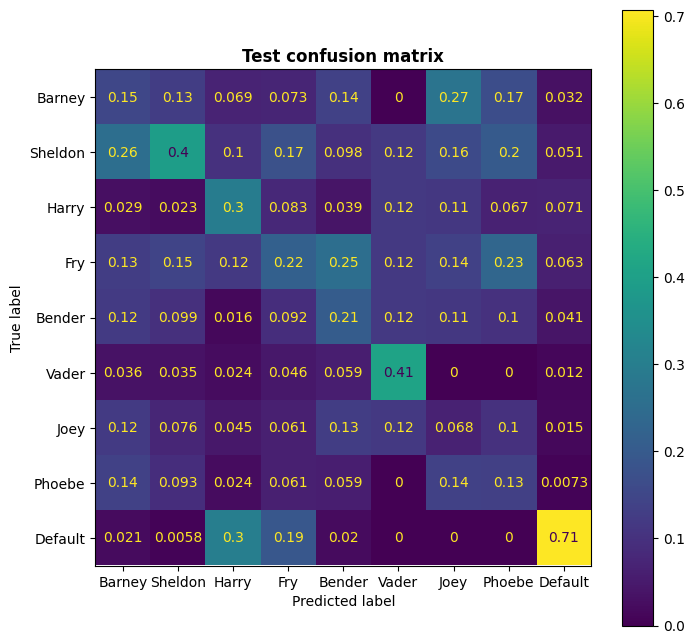

In [5]:
common_parameters = {
    "characters_path": data_folder,
    "model_path": embedder_path,
    "verbose": True,
}

if F_TRAIN_DistilBERT:
    print("Train also DistilBERT embedder...")
    # train both embedder and classifier
    distilbert_model.train(
        train_embedder = True,
        patience = 5,
        test = True,
        **common_parameters)
else:
    print("KNN training...")
    # train only the classifier
    distilbert_model.train(
        train_embedder = False,
        **common_parameters)

We retrieve the dataset used to train the model

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = distilbert_model.get_data(
    source_path = data_folder,
    val = False
)

As you can see, the training results are quite acceptable

Testing


Batches:   0%|          | 0/258 [00:00<?, ?it/s]

c:\Users\User\Documents\Unibo\TM\Project\ChatBot-Personality-Recognition\venv\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


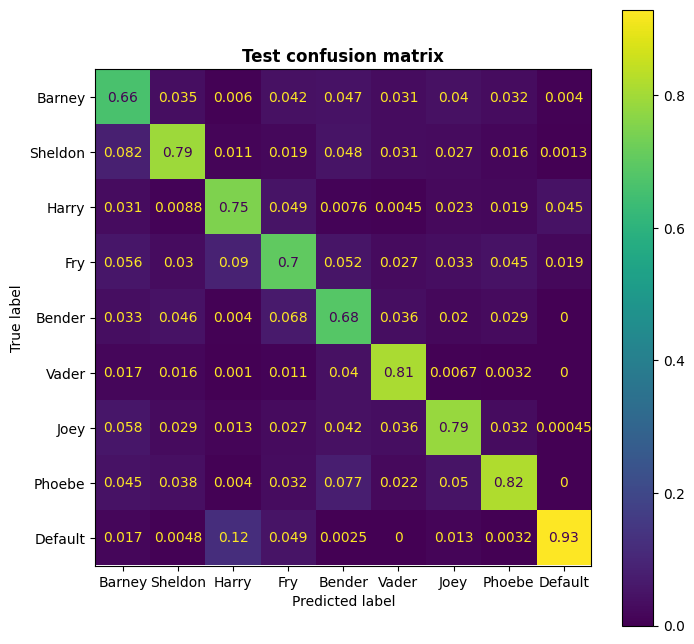

In [7]:
distilbert_model.test(X_train, y_train, verbose=True)

differently from the test set, which shows great overfitting and generalization issues 

Testing


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

c:\Users\User\Documents\Unibo\TM\Project\ChatBot-Personality-Recognition\venv\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


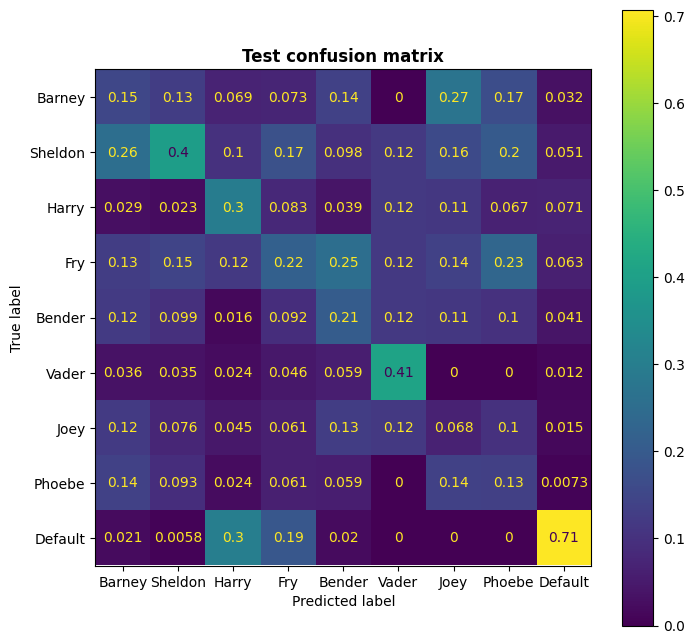

In [8]:
distilbert_model.test(X_test, y_test, verbose=True)